# Описание проекта 'Обнаружение проблем в работе оборудования'
## Задача производства
Более точное планирование заблаговременных ремонтных/ профилактических работ оборудования с учетом их текущего состояния.

## Цель задачи
Минимизировать риск внезапного выхода из строя оборудования.

## Ожидаемый результат
1. Экономия средств на ремонте или замене оборудования
2. Сокращение потерь времени на перепланирование производства в связи с выходом из строя оборудования

## Ограничения
pass

In [55]:
from datetime import timedelta
from time import perf_counter
import itertools
import pickle

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 1234

# 1. Загрузка данных

## Описание формата данных
Каждая строка в файле с данными записывается с помощью датчика вибраций каждые 0.5 сек. и состоит из следующих элементов: 
- нулевой элемент - всегда равен 12 и является сервисной информацией, означает количество максимальных амплитуд и соответствующих им частот. Обратите внимание, что столбец с данной информацией для последующей обработки не загружается.
- элементы [1-12] - максимальные амплитуды для первой оси
- элементы [13-24] - частоты первой оси, соответствующие максимальным амплитудам
- элементы [25-36] - максимальные амплитуды для второй оси
- элементы [37-48] - частоты второй оси, соответствующие максимальным амплитудам

Пример данных:  
<img src="./illustrations/raw_data_example.png" width="1300" height="900" align=left>

In [8]:
# Загрузить данные из файла
t1 = perf_counter()
path = 'correct_data.csv'
data = np.genfromtxt(fname=path, dtype=np.float64, delimiter=',', 
                     skip_header=1, usecols=range(2, 50), 
                     invalid_raise=False)
print(f"Загрузка данных завершена за {timedelta(seconds=perf_counter()-t1)}")

# Показать первую строку в данных
data[0:1]

Загрузка данных завершена за 0:00:33.438241


array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. , 25.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ]])

## 2. Разведовательный анализ данных (Exploratory Data Analysis)
Выясним есть ли проблемы с данными, такие как:
1. Пропущенные данные
2. Дублирующиеся данные
3. Выбросы

Обычно такой анализ выполняется с помощью готовых инструментов например pandas-profiling

## 3. Предобработка данных

Как лучше представить данные чтобы модель разработанная на их основе работала быстро и эффективно.
Рассмотрим данные как пакет.

In [28]:
def generate_samples(data, slice_size=20, overlap_size=2, n=12):
    """Creates input/ output samples according to the following rule:
    If X1, X2, X3, X4, X5, X6, X7, ..., Xn is the time series 
    and 'lag' is 3, so samples wil be:
    X               y
    [X1, X2, X3] -> X4,
    [X2, X3, X4] -> X5,
    ...
    [Xn-3, Xn-2, Xn-1] -> Xn
    
    Parameters
    ----------
    data: pd.DataFrame. Time series data.
    lag: int. Size of sliding window.
    data_augmentation: bool. If True, initial data will be augmented with new data.
    n_times: int. How many times new data will be added to initial data.
    mu: float. Mean for noise. 
        Noise is used to change initial data in order to create new data for augmentation.
    sigma: float. Standard deviation for noise. 
        Noise is used to change initial data in order to create new data for augmentation.
    
    Returns
    -------
    Samples: tuple. Input and output data.
    """
    
    current_idx = 0
    output = []

    while (current_idx + slice_size) <= len(data):
        part_data = data[current_idx: current_idx+slice_size]
        mean_ampl1 = np.mean(part_data[:, 0:n], axis=0)
        mean_freq1 = np.mean(part_data[:, n:2*n], axis=0)
        mean_ampl2 = np.mean(part_data[:, 2*n:3*n], axis=0)
        mean_freq2 = np.mean(part_data[:, 3*n:4*n], axis=0)

        ampl_freq_concat = np.concatenate((mean_ampl1, mean_freq1, mean_ampl2, mean_freq2))
        output.append(ampl_freq_concat)

        current_idx = current_idx + slice_size - overlap_size

    return np.array(output)

In [57]:
t1 = perf_counter()
output = generate_samples(data, slice_size=20, overlap_size=2)
print(f"Предобработка данных завершена за {timedelta(seconds=perf_counter()-t1)}")
y_ok = np.zeros(len(output))
y_ok

Предобработка данных завершена за 0:00:00.918026


array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
output.shape

(29031, 48)

## Generate abnormal data

In [58]:
noise_X = np.random.normal(0, 10, size=data.shape)
data_not_ok = np.clip(data + noise_X, a_min=0, a_max=None)
print(data_not_ok.shape)

output_not_ok = generate_samples(data_not_ok, slice_size=20, overlap_size=2)

y_not_ok = np.ones(len(output_not_ok))
y_not_ok

(522570, 48)


array([1., 1., 1., ..., 1., 1., 1.])

array([1., 1., 1., ..., 1., 1., 1.])

## Create dataset

In [59]:
X = np.concatenate((output, output_not_ok), axis=0)
y = np.concatenate((y_ok, y_not_ok), axis=0)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Разделить данные на тренировочную и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, shuffle=True, 
    random_state=seed
)

X shape: (58062, 48)
y shape: (58062,)


## Modeling

In [54]:
def plot_confusion_matrix(y_actual, y_pred, figsize=(7, 5)):
    """Plot confusion matrix.
    """
    cm = confusion_matrix(y_actual, y_pred)
#     cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = cm

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_norm, interpolation='none', cmap='coolwarm', aspect='equal')
    ax.figure.colorbar(im, ax=ax, shrink=0.85)
    ax.set_title('Confusion matrix', fontsize=14)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    categories = ['ok', 'non_ok']
    ax.set_xticklabels(categories, rotation=90)
    ax.set_yticklabels(categories)

    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        if cm_norm[i, j]!=0:
            ax.text(
                j, i,
                format(cm_norm[i, j], '.0f'),
                horizontalalignment='center', verticalalignment='center',
                color = 'white',
#                 color='black' if (0.35 < cm_norm[i, j] < 0.65) else 'white',
                fontsize=14,
                fontweight=700
            )

    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('Actual label', fontsize=14)
    ax.grid(linestyle=':')

Обучение модели завершено за 0:00:22.956094
              precision    recall  f1-score   support

         0.0       0.69      0.91      0.78      8709
         1.0       0.87      0.59      0.70      8710

    accuracy                           0.75     17419
   macro avg       0.78      0.75      0.74     17419
weighted avg       0.78      0.75      0.74     17419



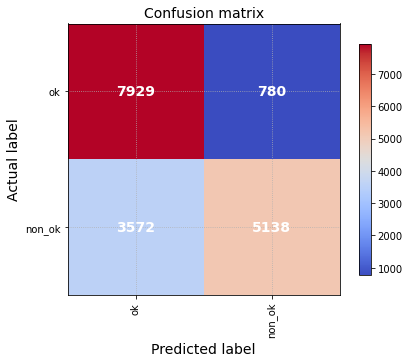

In [62]:
t1 = perf_counter()
pipe = Pipeline([
    ('preprocessor', MinMaxScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=10, weights='uniform', n_jobs=-1))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Обучение модели завершено за {timedelta(seconds=perf_counter()-t1)}")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

Обучение модели завершено за 0:00:22.603206
              precision    recall  f1-score   support

         0.0       0.33      0.34      0.33      8709
         1.0       0.32      0.31      0.31      8710

    accuracy                           0.32     17419
   macro avg       0.32      0.32      0.32     17419
weighted avg       0.32      0.32      0.32     17419



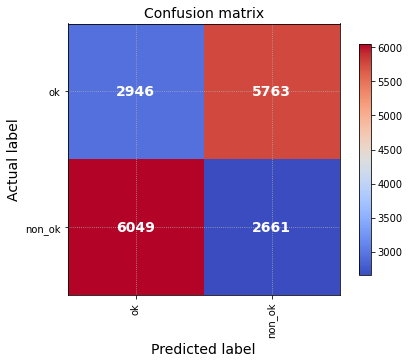

In [60]:
t1 = perf_counter()
pipe = Pipeline([
    ('preprocessor', MinMaxScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Обучение модели завершено за {timedelta(seconds=perf_counter()-t1)}")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

## Save model

In [ ]:
filename = 'finalized_model.pk'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

Обучение модели завершено за 0:00:22.392171
              precision    recall  f1-score   support

         0.0       0.15      0.15      0.15      8709
         1.0       0.15      0.15      0.15      8710

    accuracy                           0.15     17419
   macro avg       0.15      0.15      0.15     17419
weighted avg       0.15      0.15      0.15     17419



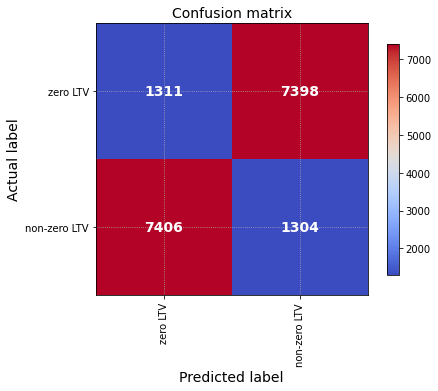

In [50]:
t1 = perf_counter()
classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f"Обучение модели завершено за {timedelta(seconds=perf_counter()-t1)}")

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)